Mount Drive & Import Necessery Libraries

In [11]:
!pip install -q roboflow ultralytics opencv-python onnx onnxruntime

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Loading

In [2]:
import os
from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("honeybee").project("honeybee_varroamite")
version = project.version(1)
dataset = version.download("yolov5")

# Yol: test klasörü
test_images_dir = os.path.join(dataset.location, "test", "images")
test_labels_dir = os.path.join(dataset.location, "test", "labels")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 130.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to HoneyBee_VarroaMite-1 in yolov5pytorch:: 100%|██████████| 7904/7904 [00:01<00:00, 4490.80it/s]


Model Performance Test

In [6]:
import torch
import cv2
import numpy as np
import os
from glob import glob

pt_model_path = "/content/drive/MyDrive/Bee-Project/pt_to_onnx/yolov5s.pt"
model = torch.hub.load('ultralytics/yolov5', 'custom', path=pt_model_path, force_reload=True)
model.conf = 0.5
model.iou = 0.5

target_size = 320
test_images_dir = "/content/HoneyBee_VarroaMite-1/test/images"
test_labels_dir = "/content/HoneyBee_VarroaMite-1/test/labels"

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(1, (boxA[2] - boxA[0])) * max(1, (boxA[3] - boxA[1]))
    boxBArea = max(1, (boxB[2] - boxB[0])) * max(1, (boxB[3] - boxB[1]))
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


TP = 0
FP = 0
FN = 0
ious = []

for img_path in sorted(glob(os.path.join(test_images_dir, "*.jpg"))):
    filename = os.path.basename(img_path).replace(".jpg", ".txt")
    label_path = os.path.join(test_labels_dir, filename)
    if not os.path.exists(label_path):
        continue

    img = cv2.imread(img_path)
    orig_h, orig_w = img.shape[:2]

    img_resized = cv2.resize(img, (target_size, target_size))

    results = model(img_resized[..., ::-1])
    pred_boxes_raw = results.xyxy[0].cpu().numpy()
    pred_boxes = [box[:4].tolist() for box in pred_boxes_raw]

    gt_boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            cls, cx, cy, w, h = map(float, line.strip().split())
            x1 = (cx - w / 2) * target_size
            y1 = (cy - h / 2) * target_size
            x2 = (cx + w / 2) * target_size
            y2 = (cy + h / 2) * target_size
            gt_boxes.append([x1, y1, x2, y2])

    matched_gt = set()
    matched_pred = set()

    for i, gt in enumerate(gt_boxes):
        best_iou = 0
        best_j = -1
        for j, pred in enumerate(pred_boxes):
            if j in matched_pred:
                continue
            iou = compute_iou(gt, pred)
            if iou > best_iou:
                best_iou = iou
                best_j = j
        if best_iou >= 0.5:
            TP += 1
            matched_gt.add(i)
            matched_pred.add(best_j)
            ious.append(best_iou)
        else:
            FN += 1

    FP += len(pred_boxes) - len(matched_pred)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
map50 = sum(ious) / len(ious) if ious else 0

print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"mAP@0.5:   {map50:.4f}")


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-5-19 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Pleas

TP: 393
FP: 47
FN: 68
Precision: 0.8932
Recall:    0.8525
F1 Score:  0.8724
mAP@0.5:   0.6984


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


In [7]:
import torch
import cv2
import numpy as np
import os
from glob import glob

pt_model_path = "/content/drive/MyDrive/Bee-Project/pt_to_onnx/yolov5n.pt"
model = torch.hub.load('ultralytics/yolov5', 'custom', path=pt_model_path, force_reload=True)
model.conf = 0.5
model.iou = 0.5

target_size = 320
test_images_dir = "/content/HoneyBee_VarroaMite-1/test/images"
test_labels_dir = "/content/HoneyBee_VarroaMite-1/test/labels"

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(1, (boxA[2] - boxA[0])) * max(1, (boxA[3] - boxA[1]))
    boxBArea = max(1, (boxB[2] - boxB[0])) * max(1, (boxB[3] - boxB[1]))
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

TP = 0
FP = 0
FN = 0
ious = []

for img_path in sorted(glob(os.path.join(test_images_dir, "*.jpg"))):
    filename = os.path.basename(img_path).replace(".jpg", ".txt")
    label_path = os.path.join(test_labels_dir, filename)
    if not os.path.exists(label_path):
        continue

    img = cv2.imread(img_path)
    orig_h, orig_w = img.shape[:2]

    img_resized = cv2.resize(img, (target_size, target_size))

    results = model(img_resized[..., ::-1])
    pred_boxes_raw = results.xyxy[0].cpu().numpy()
    pred_boxes = [box[:4].tolist() for box in pred_boxes_raw]

    gt_boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            cls, cx, cy, w, h = map(float, line.strip().split())
            x1 = (cx - w / 2) * target_size
            y1 = (cy - h / 2) * target_size
            x2 = (cx + w / 2) * target_size
            y2 = (cy + h / 2) * target_size
            gt_boxes.append([x1, y1, x2, y2])

    matched_gt = set()
    matched_pred = set()

    for i, gt in enumerate(gt_boxes):
        best_iou = 0
        best_j = -1
        for j, pred in enumerate(pred_boxes):
            if j in matched_pred:
                continue
            iou = compute_iou(gt, pred)
            if iou > best_iou:
                best_iou = iou
                best_j = j
        if best_iou >= 0.5:
            TP += 1
            matched_gt.add(i)
            matched_pred.add(best_j)
            ious.append(best_iou)
        else:
            FN += 1

    FP += len(pred_boxes) - len(matched_pred)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
map50 = sum(ious) / len(ious) if ious else 0

print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"mAP@0.5:   {map50:.4f}")

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-5-19 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please

TP: 346
FP: 235
FN: 115
Precision: 0.5955
Recall:    0.7505
F1 Score:  0.6641
mAP@0.5:   0.6662


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Import YOLOv5 GitHub Repo

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17436, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 17436 (delta 77), reused 29 (delta 29), pack-reused 17329 (from 2)
Receiving objects: 100% (17436/17436), 16.31 MiB | 29.26 MiB/s, done.
Resolving deltas: 100% (11950/11950), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/

Converting PyTorch Model to ONNX Model

In [ ]:
import torch

!python export.py --weights /content/drive/MyDrive/Bee-Project/pt_to_onnx/yolov5n.pt --img 320 --batch 1 --include onnx --simplify --opset 12

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
export: data=data/coco128.yaml, weights=['/content/drive/MyDrive/Bee-Project/pt_to_onnx/yolov5n.pt'], imgsz=[320], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=True, mlmodel=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-417-g2ef88637 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs

PyTorch: starting from /content/drive/MyDrive/Bee-Project/pt_to_onnx/yolov5n.pt with output shape (1

In [12]:
import onnx
model = onnx.load('/content/drive/MyDrive/Bee-Project/pt_to_onnx/yolov5s.onnx')
print([node.name for node in model.graph.input])

['images']


Test Model ONNX Format And Save Results to Drive

In [8]:
import onnxruntime as ort
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
from glob import glob

input_dir = "/content/drive/MyDrive/Bee-Project/pt_to_onnx/images"
output_dir = "/content/drive/MyDrive/Bee-Project/pt_to_onnx/predicted_images"
onnx_path = "/content/drive/MyDrive/Bee-Project/pt_to_onnx/yolov5n.onnx"

os.makedirs(output_dir, exist_ok=True)

session = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name

def preprocess(img_path, input_shape=(320, 320)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, input_shape)
    orig = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img, orig

def postprocess(pred, conf_threshold=0.5):
    pred = pred[0]
    boxes = []
    for x, y, w, h, conf, cls in pred:
        if conf > conf_threshold:
            x1 = int(x - w / 2)
            y1 = int(y - h / 2)
            x2 = int(x + w / 2)
            y2 = int(y + h / 2)
            boxes.append((x1, y1, x2, y2, conf, int(cls)))
    return boxes

def draw_boxes(img, boxes):
    for x1, y1, x2, y2, conf, cls in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{cls}:{conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return img

image_paths = sorted(glob(os.path.join(input_dir, "*")))
for idx, img_path in enumerate(image_paths, start=1):
    try:
        img_input, original = preprocess(img_path)
        outputs = session.run(None, {input_name: img_input})
        boxes = postprocess(outputs[0])
        result = draw_boxes(original, boxes)
        save_path = os.path.join(output_dir, f"{idx}.jpg")
        cv2.imwrite(save_path, result)
    except Exception as e:
        print(f"Hata: {img_path} dosyası işlenemedi -> {e}")


Show Random Image

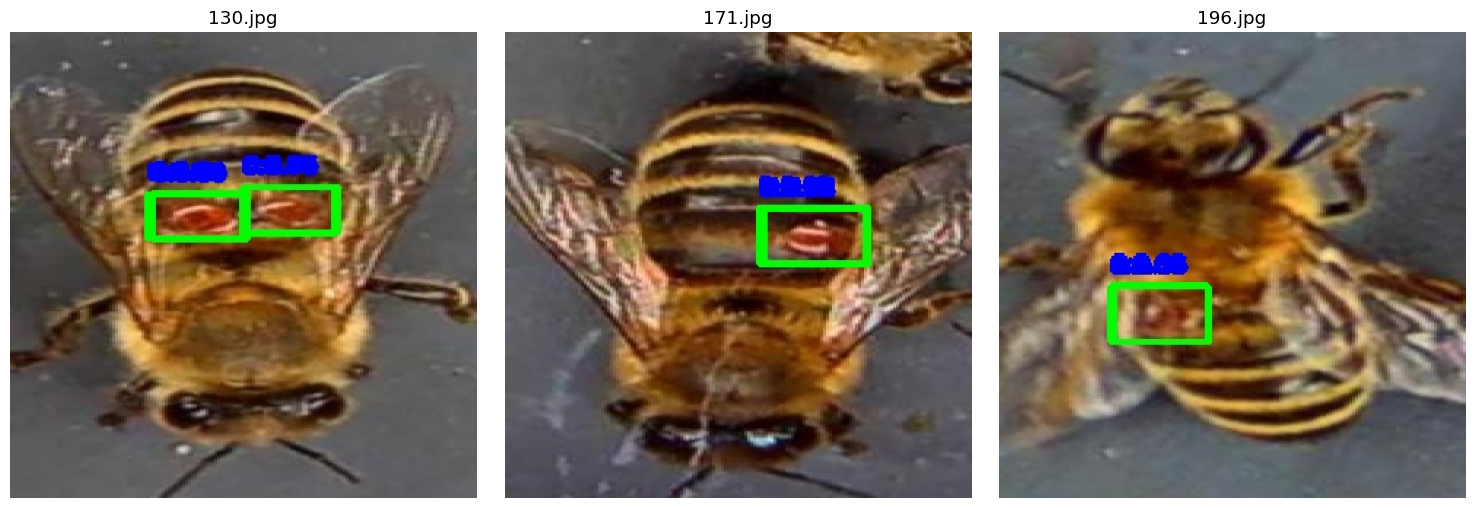

In [22]:
%matplotlib inline

import glob
import random
import cv2
import matplotlib.pyplot as plt

output_dir = "/content/drive/MyDrive/Bee-Project/pt_to_onnx/predicted_images"

image_paths = sorted(glob.glob(f"{output_dir}/*.jpg"))

if len(image_paths) < 3:
    print("Yeterli sayıda görsel yok.")
else:
    selected_images = random.sample(image_paths, 3)
    plt.figure(figsize=(15, 5))
    for idx, img_path in enumerate(selected_images):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Görsel yüklenemedi: {img_path}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, idx + 1)
        plt.imshow(img_rgb)
        plt.title(img_path.split('/')[-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
